# Generalised Spatial Regression with Partial Differential Equation Regularization
Ilenia Di Battista, Alessandro Palummo @ fdaPDE Team, MOX, Department of Mathematics, Politecnico di Milano, Italy

`fdaPDE` (Palummo et al., 2025) is a C++ library with an interface to R and Python for *physics-informed spatial and functional data analysis*, at the intersection of statistics and numerical analysis. The library provides advanced statistical methods designed for data located over complex spatial domains, ranging from irregular planar regions and curved surfaces to linear networks and volumes, possibly evolving over time. The class of methods implemented in `fdaPDE` features regularization terms based on Partial Differential Equations (PDEs), which allow incorporating information derived from the physics of the problem under study into the statistical modeling. This makes `fdaPDE` an extremely flexible tool for the analysis of complex data. For a review of this class of methods, refer to  Sangalli (2021).

`fdaPDE` offers a wide range of modeling capabilities -- including regression, nonparametric
density estimation, functional data analysis, and more -- for data located over a spatial domain,
possibly evolving over time. Among the broad range of modeling capabilities offered by `fdaPDE`, we focus here on the **generalized spatial regression method**.

## Model

Let $\mathcal{D} \subset \mathbb{R}^d\,,$ with $d \geq 1\,,$ be a bounded *spatial domain* of interest in which $n$ fixed *measurement stations* are located. Here, we consider $d = 2\,,$ but the proposed method can handle multidimensional spatial domains with complex shapes, including *two-dimensional curved surfaces* (Ettinger et al., 2016) and *non-convex three-dimensional volumes*  (Arnone et al., 2023). At the location $\mathbf{p}_i = (p_{1i}, p_{2i})^\top \in \mathcal{D}$ of each station, we observe a realization $y_i \in \mathbb{R}$ of the response variable $Y_i$ under study, along with a set of covariates $\mathbf{x}_i = \left( x_{i,1},\ldots,x_{i,q} \right)^\top \in \mathbb{R}^q\,,$ if available. Specifically, we assume that $Y_i$ follows a distribution from the exponential family, with mean $\mu_i$ and a common scale parameter $\phi\,,$ for $i = 1, \ldots, n\,.$ In the context of spatial regression, we present a **generalized additive model** with Partial Differential Equation (PDE) regularization, which we formulate according to Wilhelm & Sangalli (2016), as follows:
$$g(\mu_i) = \theta_i = \mathbf{x}_i^\top \boldsymbol{\beta} + f(\mathbf{p}_i) \,, \qquad i = 1, \ldots, n,$$

where:

- $g$ is a continuously differentiable and strictly monotone **canonical link function**, whereas $\theta_i = \theta_i(\boldsymbol{\beta}, f)$ is referred to as the $i$th **canonical parameter**;

- $\boldsymbol{\beta} \in \mathbb{R}^q$ is the vector of **unknown regression coefficients** capturing the mean effects of the covariates;

- $f(\mathbf{p}_i) \in \mathbb{R}$ is the **unknown deterministic spatial field** $f : \mathcal{D} \to \mathbb{R}$ at the $i$th data location.

To estimate the unknown parameters, we refer to the basic form of the regularized methods, as reviewed in Sangalli (2021) and originally introduced in Sangalli et al. (2013). These works propose to maximize the following penalized functional based on the log-likelihood $\ell(\cdot ; \boldsymbol{\theta})$ for the considered distribution:
$$\sum_{i = 1}^n \ell\left( y_i; \theta_i \right) - R(f; \lambda)\,,$$

where $R(f; \lambda)$ is the **regularization term** that depends on the **smoothing parameter** $\lambda \in \mathbb{R}^+\,.$ The regularization term is defined using PDEs, with differential operators encoding the smoothness of $f$ over $\mathcal{D}\,.$ This term may also incorporate problem-specific information into the modeling framework, whenever available. The functional above embodies the trade-off between *data fidelity* and *model fidelity* through the least-squares term and the misfit with respect to the PDE, respectively. The balance between these two contributions is governed by the smoothing parameter. When the considered distribution is Gaussian, the optimization of the functional above coincides with the one that follows from the basic form of spatial regression with PDE regularization.

In its basic form, the regularization term is given by:
$$R(f; \lambda) = \lambda \int_\mathcal{D} \left( \Delta f (\mathbf{p}) \right)^2 \, \text{d}\mathbf{p}\,,$$


where the Laplacian operator is defined as
$$\Delta f = \frac{\partial^2 f}{\partial p_1^2} + \frac{\partial^2 f}{\partial p_2^2}$$


and is a measure of the local curvature of the field $f\,.$ More complex roughness penalties may be considered in the regularization term, with the PDE modeling the spatial variation of the unknown spatial field $f\,,$ thereby accounting for spatial non-stationarities and anisotropies, as discussed in Wilhelm & Sangalli (2016).

In this notebook we describe how the `fdaPDE` library gives easy access to the described physics-informed Generalized Spatial Regression model , hereafter referred to as `GSR-PDE`.

In [ ]:
## Google-colab setup cell, you can skip this cell if you are running the notebook locally
import sys

if "google.colab" in sys.modules:
  # clone data and utilites
  !git clone https://github.com/fdaPDE/course-materials.git
  %cd course-materials/courses/[2026-Rome]-Advanced-Topics-in-Statistical-Machine-Learning/notebook

  # install dependencies
  !pip install numpy matplotlib pandas geopandas folium branca rasterio rioxarray seaborn IPython
  !pip install -i https://test.pypi.org/simple/ fdaPDE

We start by loading some additional Python libraries and helper functions used for graphical purposes only:

In [1]:
# Import additional libraries 
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

# Load helper functions for plotting
import sys
sys.path.append("..")

from utils.utils import (
    plot_domain, 
    plot_locations,
    plot_areal_data,
    plot_areal_estimate,
    display_folium_map
)


## Application to fire count data in Southern Italy

As a benchmark application in environmental sciences, we consider *fire count data* recorded in Southern Italy, during 2021. In addition to fire counts per administrative division (province), the dataset also includes several *areal covariates*, such as area, elevation, average temperature, solar radiation, total precipitation, population, land use, and land cover, as of 2021. The dataset is freely and publicly available by different data sources, including the [Fire Information for Resource Management System (FIRMS)](https://firms.modaps.eosdis.nasa.gov) of the National Aeronautics and Space Administration (NASA), the [CORINE Land Cover (CLC)](https://land.copernicus.eu/en) from the European Environment Agency (EEA), the [Digital Elevation Model (DEM)](https://tinitaly.pi.ingv.it/Download_Area1_1.html) from the National Institute of Geophysics and Volcanology (INGV), and the [Copernicus ERA5](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-land?tab=overview) from the European Centre for Medium-Range Weather Forecasts (ECMWF) as part of the Copernicus Climate Change Service (C3S). Due to ongoing climate change and global warming, large-scale wildfires are occurring with increasing frequency worldwide, especially in southern Europe. This results in severe repercussions and damage to ecosystems, infrastructures, material assets, and socio-economic activities. Therefore, an in-depth statistical analysis of this phenomenon is becoming crucial for driving the implementation of new policies aimed at preserving both artificial and natural environments.

### 1. Spatial domain
We import the preprocessed data observed in Southern Italy during 2021 from the shapefile `GSRPDE_2D/GSRPDE_2D_data.shx` as a `geopandas.GeoDataFrame` (GeoPandas Developers, 2024) object.

In [2]:
## [SPATIAL DOMAIN]
# Load domain
domain = gpd.read_file("../Data/GSRPDE_2D/GSRPDE_2D_data.shx")

print(domain.shape)
domain.head()

(33, 18)


COUNTRY    REGION               PROVINCE TERRITORY       AREA  MIN_ELEV  \
0   Italy   Sicilia              Agrigento    Island  3025.2833    0.5303   
1   Italy  Campania               Avellino     South  2803.7111   92.7902   
2   Italy    Puglia                   Bari     South  3797.7125    1.0050   
3   Italy    Puglia  Barletta-Andria-Trani     South  1524.3469    0.4824   
4   Italy  Campania              Benevento     South  2045.4289   33.2261   

   AVG_ELEV   MAX_ELEV  ARTIFIC  AGRICUL  FOREST  WETLANDS   WATER  \
0  310.0765  1414.2872   0.0360   0.7901  0.1641    0.0002  0.0096   
1  610.1539  1695.8716   0.0445   0.6325  0.3213    0.0002  0.0015   
2  302.0524   659.2282   0.0633   0.8279  0.1074    0.0000  0.0014   
3  217.2597   657.4872   0.0448   0.8197  0.1005    0.0303  0.0047   
4  479.9234  1719.1609   0.0371   0.7076  0.2527    0.0000  0.0026   

   FIRE_COUNT        POP  REF_AREA  POP_DENS  \
0         306   413177.0   3052.82  135.3427   
1          16   398932.0   2805.96  142.1731   
2          75  1225048.0   3862.66  317.1514   
3          26   379509.0   1542.99  245.9569   
4          17   263125.0   2080.37  126.4799   

                                            geometry  
0  POLYGON ((12.89625 37.57708, 12.91565 37.63784...  
1  POLYGON ((14.60641 40.84862, 14.57799 40.88159...  
2  POLYGON ((17.35441 40.74957, 17.30543 40.74445...  
3  POLYGON ((16.20329 40.91851, 16.1638 40.92956,...  
4  MULTIPOLYGON (((14.5728 41.01051, 14.53203 41....


Before discussing the data in detail, we visualize the boundaries of each province within the spatial domain of interest in Southern Italy. These boundaries are already embedded in the `GeoDataFrame` object loaded above. To enable interactive visualization, we use the `folium` Python package (Python Visualization Team, 2024).

In [3]:
# Intercative plot
plot_domain(
    domain_shape=domain,
    fill_color="grey",
    border_color="black",
    fill_opacity=0.5,
    zoom_start=6,
    popup_label="PROVINCE"
)


Figure 1: Boundaries of each of the 33 provinces in Southern Italy.

Now we build a **regular mesh** of the spatial domain above. We first read the mesh nodes, mesh elements and domain boundaries files already preprocessed.

In [4]:
## [MESH]
# Read mesh nodes, boundary nodes and mesh elements
mesh_nodes    = np.loadtxt("../Data/GSRPDE_2D/nodes.txt"  , dtype = float)
mesh_cells    = np.loadtxt("../Data/GSRPDE_2D/cells.txt", dtype = int  )
mesh_boundary_nodes = np.loadtxt("../Data/GSRPDE_2D/boundary_coords.txt", dtype = float)
mesh_boundary = np.loadtxt("../Data/GSRPDE_2D/boundary.txt", dtype = float)

# Print shapes
print(f"Mesh nodes shape: {mesh_nodes.shape}")
print(f"Mesh cells shape: {mesh_cells.shape}\n")

# Print first 5 boundary nodes
print("First 5 coordinates of boundary nodes (lon/lat):")
print(mesh_boundary_nodes[:5, :], "\n")


Mesh nodes shape: (2563, 2)
Mesh cells shape: (4514, 3)

First 5 coordinates of boundary nodes (lon/lat):
[[12.89624977 37.57707977]
 [12.91565323 37.63784027]
 [12.89095306 37.64172745]
 [12.91856003 37.69039536]
 [12.96501541 37.73036957]] 



In [5]:
# Import Mesh from the geometry module
from fdaPDE.geometry import Mesh

# Define mesh of the spatial domain
mesh_italy = Mesh(
    nodes = mesh_nodes,
    cells = mesh_cells,
    boundary = mesh_boundary
)

# Print short summary of the mesh
print(mesh_italy)


2D mesh
Bounding box:   xmin: 12.442082 ymin: 36.64986 xmax: 18.5206947330001 ymax: 42.8937492370001
Number of nodes: 2563
Number of cells: 4514


We visualize the resulting mesh of the spatial domain of interest.

In [6]:
# Interactive plot
mesh_italy.mapplot(
    domain_fill_opacity=0.3,
    domain_shape=domain,
    zoom_start = 6,
    mesh_weight=0.6,
    mesh_opacity=0.7
)


Figure 2: Regular mesh of the spatial domain of interest of Southern Italy with $2\,563$ nodes and $4\,514$ triangles. Note that the mesh conforms to the boundaries of the provinces.

We use the triangulation just created to define the spatial support of a `GeoFrame` object. This object will host layers containing data observed over the spatial support.

In [7]:
# Import GeoFrame from fdaPDE
from fdaPDE import GeoFrame

# Create the geoframe 
italy = GeoFrame(domain = mesh_italy)
print(italy)

Geoframe with 0 layers
Bounding box:   xmin: 12.442082 ymin: 36.64986 xmax: 18.5206947330001 ymax: 42.8937492370001
Number of nodes: 2563
Number of cells: 4514



### 2. Data

We briefly introduce the data under study.  We add a data layer to the `GeoFrame` object defined above, thus obtaining a format compatible with the implementation of the proposed regression method.

In [8]:
## [DATA]
# Add layer with data to the geoframe object (directly from the shapefile)
italy.load_shp(layer = "fires", filename="../Data/GSRPDE_2D/GSRPDE_2D_data.shp")

print(italy)

Geoframe with 1 layer
Bounding box:   xmin: 12.442082 ymin: 36.64986 xmax: 18.5206947330001 ymax: 42.8937492370001
Number of nodes: 2563
Number of cells: 4514

Layer: fires
Type:  AREAL
Dims:  33, 17
First 6 data rows:
                                       COUNTRY   REGION              PROVINCE TERRITORY        AREA  MIN_ELEV   AVG_ELEV    MAX_ELEV  ARTIFIC  AGRICUL   FOREST WETLANDS    WATER FIRE_COUNT            POP    REF_AREA   POP_DENS
                             <POLYGON>   <str>    <str>                 <str>     <str>     <flt64>   <flt64>    <flt64>     <flt64>  <flt64>  <flt64>  <flt64>  <flt64>  <flt64>    <flt64>        <flt64>     <flt64>    <flt64>
 [(13.75, 37.15), ..., (14.04, 37.11)]   Italy  Sicilia             Agrigento    Island 3025.283300  0.530300 310.076500 1414.287200 0.036000 0.790100 0.164100 0.000200 0.009600 306.000000  413177.000000 3052.820000 135.342700
 [(14.98, 41.09), ..., (14.96, 41.18)]   Italy Campania              Avellino     South 2803.711100 

The variables observed at the province level are given by:

- "COUNTRY", "REGION", "PROVINCE": names of the country, region, and province;

- "TERRITORY": type of territory ("South", "Island");

- "AREA": area (in $\text{km}^2$);

- "MIN_ELEV", "AVG_ELEV", "MAX_ELEV": minimum, average, and maximum elevation (in $\text{m}$);

- "ARTIFIC", "AGRICUL", "FOREST", "WETLANDS", "WATER": percentages of artificial areas, agricultural areas, forest and seminatural areas, wetlands, and water bodies;

- "FIRE_COUNT": number of fires recorded in 2021;

- "POP", "REF_AREA", "POP_DENS": population, reference area, and population density.

In addition, "geometry" contains the multipolygons defining the provinces under study.

The values of most of these variables, recorded by province in 2021, are shown in the interactive plot below, created using `folium`.

In [9]:
# Color palettes
color_palette_fire_counts = ["#FFFFB2", "#FECC5C", "#FD8D3C", "#F03B20", "#BD0026"]
color_palette_population =["#DEEBF7", "#9ECAE1", "#6BAED6", "#3182BD", "#08519C"]
color_palette_forest = ["#E5F5E0", "#A1D99B", "#74C476", "#31A354", "#006D2C"]
color_palette_elevation = ["#006400", "#A2CD5A", "#F5DEB3", "#8B864E", "#8B2323"]

# Interactive plot
m_fires = plot_areal_data(domain_shape=domain, value_column="FIRE_COUNT", palette=color_palette_fire_counts, legend_name="FIRE COUNTS" )
m_pop = plot_areal_data(domain_shape=domain, value_column="POP", palette=color_palette_population, legend_name="POPULATION" )
m_forest = plot_areal_data(domain_shape=domain, value_column="FOREST", palette=color_palette_forest, legend_name="FOREST" )
m_elev = plot_areal_data(domain_shape=domain, value_column="AVG_ELEV", palette=color_palette_elevation, legend_name="AVERAGE ELEVATION" )


display_folium_map(
    maps=[m_fires, m_pop, m_forest, m_elev],
    nrows=2,
    ncols=2,
    cell_height="500px"  
)

Figure 3: Fire counts observed at 33 provinces in Southern Italy during 2021 (top left); population measured at the province level as of 2021 (top right); forest and seminatural areas (in $\text{km}^2$) measured at the province level as of 2021 (bottom left); average elevation (in $\text{m}$) measured at the province level as of 2021 (bottom right).


First, we focus on the FIRE_COUNT variable. The *non-standard shape* of the spatial domain strongly influences the quantity under study. For example, fire counts recorded in the two provinces facing the Strait of Messina, namely the provinces of Messina in Sicily and Reggio-Calabria in Calabria, are not highly correlated. This spatial variation suggests that fire counts depends on factors beyond purely environmental ones (e.g., temperature, elevation, land cover), which typically vary smoothly across space. Specifically, differences in fire counts may be partly due to the varying number of arson incidents reported in 2021 in the two provinces, highlighting the role of unobserved cultural and social phenomena, which may not be fully captured by methods that rely solely on Euclidean distances. Differently, `GSR-PDE` naturally accounts for the geometry of the domain, which may feature disjoint regions with irregular boundaries and concavities, as in the case under consideration.

### 3. GSR-PDE model fitting for Poisson response (without covariates)

We are ready to perform the `GSR-PDE` spatial regression method using the `GSRPDE` function. This function offers several options for solving the regression problem, including the possibility to specify covariates, PDE parameters, and boundary conditions, whenever available. The `GSRPDE` function supports several distributions within the exponential family for generalized linear models and can handle areal data, as in the case under study. In addition, the function implements different algorithms for degrees of freedom computation and criteria for optimal smoothing parameter selection. 

#### 3.1 Isotropic smoothing with optimal smoothing parameter via Generalized Cross-Validation (GCV) minimization using grid search method

Here, in its simplest form, we apply a penalized Poisson regression without covariates and with isotropic smoothing to the areal fire count data, which corresponds to incorporating the Laplace operator in the regularization term. Specifically, we assume that each response variable $Y_i$ is Poisson-distributed with mean $\mu_i\,,$ for $i = 1,\ldots,n\,,$ with $n = 33$ being the number of provinces in the dataset. We consider the following model:
$$\log(\mu_i) = \theta_i = f(\mathbf{p}_i) \,, \qquad i = 1, \ldots, n\,.$$

In [10]:
# Import FeFunction, GSRPDE, gcv, grid_search from fdaPDE
from fdaPDE.fem import FeFunction
from fdaPDE.models import GSRPDE, GCV
from fdaPDE.optimization import GridSearch

## [ISOTROPIC SMOOTHING WITH OPTIMAL SMOOTHING PARAMETER]
# Set up the finite element function (order 1)
f_fires = FeFunction(domain = mesh_italy, fe_type = "P1")

# Proposed values for the smoothing parameter
lambda_grid = 10**(np.arange(-5.0, -2.25, 0.25))   

# Isotropic smoothing model
model_fires = GSRPDE("FIRE_COUNT ~ f_fires", data = italy, family="poisson", penalty = None)

# Isotropic smoothing fit with grid search for GCV minimization
fit_fires = model_fires.fit(calibration_ = GCV(optimizer = GridSearch(lambda_grid), seed=425)) 


We print the regression model outputs.

In [11]:
# Fitted values at mesh nodes
print(f"Fitted values at mesh nodes: {f_fires.coeff[:5]}")
print(f"Fitted values at locations: {model_fires.fitted[:5]}")


Fitted values at mesh nodes: [20.50016494 19.88913418 17.30043562 16.39438285 15.64136465]
Fitted values at locations: [298.92653855  19.75702522  89.84015192   6.96082961  17.33620049]



Moreover, it is possible to inspect the behavior of the GCV indices as a function of the values proposed for the smoothing parameter $\lambda\,.$

lambda_opt = 3.1623e-04


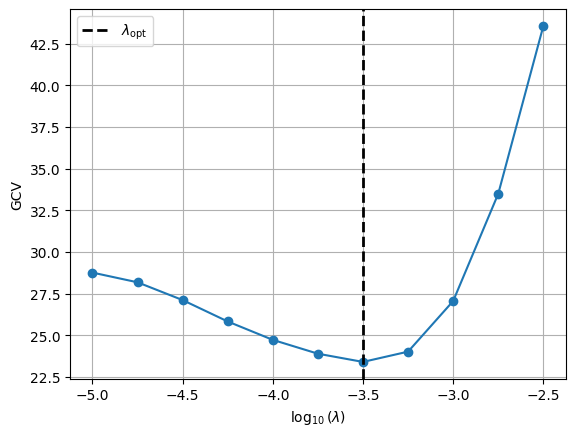

In [12]:
# GCV indices
gcv_values = fit_fires["values"] 

# Optimal value selected for the smoothing parameter
lambda_opt = fit_fires["optimum"]
print(f"lambda_opt = {lambda_opt:.4e}")

# Plot of the GCV curve
plt.plot(np.log10(lambda_grid), gcv_values, '-o')   
plt.xlabel(r"$\log_{10}(\lambda)$")
plt.ylabel("GCV")

plt.axvline(
    np.log10(lambda_opt),
    linestyle="--",
    linewidth=2,
    color="black",
    label=r"$\lambda_{\mathrm{opt}}$"
)

plt.grid(True)
plt.legend()
plt.show()

Figure 4: GCV curve.

The GCV curve is convex with minimum realized at the optimal value selected by the method -- specifically, $3.161e-4\,.$

The regression model fit over the provinces of interest is displayed below (left). For qualitative comparison, the fire count data is also displayed (right).

In [13]:
# Compute areal estimate by province
f_grid_areal = model_fires.fitted  

print(f_grid_areal.min(), f_grid_areal.max())

# Interactive plot
# Color palettes
color_palette_fire_counts = ["#FFFFB2", "#FECC5C", "#FD8D3C", "#F03B20", "#BD0026"]

# Interactive plot
m_areal_estimate = plot_areal_estimate(domain_shape=domain, values = f_grid_areal, palette=color_palette_fire_counts )
m_data = plot_areal_data(domain_shape=domain, value_column="FIRE_COUNT", palette=color_palette_fire_counts, legend_name="FIRE COUNTS" )

display_folium_map(
    maps=[m_areal_estimate, m_data],
    nrows=1,
    ncols=2,
    cell_height="500px"  
)


5.234528259000703 523.8327473550236


Figure 5: Estimated spatial field of the fire counts provided by the isotropic `GSR-PDE` for each province without covariates and with $\lambda$ selected via GCV minimization using grid search method (left); fire counts observed at 33 provinces in Southern Italy during 2021 (right). We recall that the latter are not used for estimation purposes; they are displayed here solely to allow comparison with the fire counts estimate computed by the proposed `GSR-PDE` method based on the observations loaded above.

The smoothing fit appears very accurate.

### 4. Further analysis

The phenomenon under study is influenced by several factors, including the average elevation, the population, the type of territory, as well as the extent of artificial areas, agricultural areas, forest and seminatural areas, wetlands and water bodies, all measured at the province level as of 2021. These covariates could be incorporated into the `GSR-PDE` modeling framework to better explain fire count data in Southern Italy.

Moreover, as a future development, the model fitting could leverage problem-specific information derived from the physics of the underlying factors influencing the phenomenon considered here. In particular, the regularization term could incorporate a PDE accounting for the presence of wind across the provinces.

## References


Arnone, E., Negri, L., Panzica, F., & Sangalli, L. M. (2023). Analyzing data in complicated 3D domains: Smoothing, semiparametric regression, and functional principal component analysis. Biometrics, 79(4), 3510–3521. https://doi.org/10.1111/biom.13845

Begu, B., Panzeri, S., Arnone, E., Carey, M., & Sangalli, L. M. (2024). A nonparametric penalized likelihood approach to density estimation of space-time point patterns. Spatial Statistics. https://doi.org/10.1016/j.spasta.2024.100824

Ettinger, B., Perotto, S., & Sangalli, L. M. (2016). Spatial regression models over two-dimensional manifolds. Biometrika, 103(1), 71–88.

Ferraccioli, F., Arnone, E., Finos, L., Ramsay, J. O., & Sangalli, L. M. (2021). Nonparametric density estimation over complicated domains. Journal of the Royal Statistical Society Series B: Statistical Methodology, 83(2), 346–368. https://doi.org/10.1111/rssb.12415

GeoPandas Developers. (2024). GeoPandas (Version 1.1.2) [Computer software]. https://geopandas.org

Palummo, A., Clemente, A., Sangalli, E., Arnone, Formaggia, L., & Maria, L. (2025). fdaPDE: Physics-informed statistical learning. url: https://github.com/fdaPDE/fdaPDE-R.

Python Visualization Team. (2024). Folium (Version 0.20.0) [Computer software]. https://github.com/python-visualization/folium

Sangalli, L. M. (2021). Spatial regression with partial differential equation regularisation. International Statistical Review, 89(3), 505–531. https://doi.org/10.1111/insr.12444

Sangalli, L. M., Ramsay, J. O., & Ramsay, T. O. (2013). Spatial spline regression models. Journal of the Royal Statistical Society Series B: Statistical Methodology, 75(4), 681–703. https://doi.org/10.1111/rssb.12009

Wilhelm, M., & Sangalli, L. M. (2016). Generalized spatial regression with differential regularization. Journal of Statistical Computation and Simulation, 86(13), 2497–2518. https://doi.org/10.1080/00949655.2016.1182532

